In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, mean_absolute_error
import joblib

In [ ]:
# 1. Load Dataset (Using Hugging Face Codeforces dataset as proxy)
print("Loading dataset...")
# We use the 'open-r1/codeforces' dataset which matches requirements
dataset = load_dataset("open-r1/codeforces", split="train")
df = pd.DataFrame(dataset)

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00011.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

data/train-00001-of-00011.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

data/train-00002-of-00011.parquet:   0%|          | 0.00/152M [00:00<?, ?B/s]

data/train-00003-of-00011.parquet:   0%|          | 0.00/67.5M [00:00<?, ?B/s]

data/train-00004-of-00011.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

data/train-00005-of-00011.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00006-of-00011.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

data/train-00007-of-00011.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

data/train-00008-of-00011.parquet:   0%|          | 0.00/337M [00:00<?, ?B/s]

data/train-00009-of-00011.parquet:   0%|          | 0.00/111M [00:00<?, ?B/s]

data/train-00010-of-00011.parquet:   0%|          | 0.00/179M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/35.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9556 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/468 [00:00<?, ? examples/s]

In [3]:
df

,id,aliases,contest_id,contest_name,contest_type,contest_start,contest_start_year,index,time_limit,memory_limit,...,editorial,rating,tags,testset_size,official_tests,official_tests_complete,input_mode,generated_checker,executable,generated_tests
0,852/A,None,852,Bubble Cup X - Finals [Online Mirror],ICPC,1504432800,2017,A,1.0,256.0,...,None,2500.0,"[brute force, implementation, math]",46,"[{'input': '1 1 ', 'output': '1 1 1 '}, {...",False,stdio,"import sys\n\ndef main(input_path, output_path...",True,19
1,852/B,None,852,Bubble Cup X - Finals [Online Mirror],ICPC,1504432800,2017,B,2.0,256.0,...,None,2000.0,"[dp, matrices]",20,"[{'input': '2 3 13 4 6 2 1 3 4 ', 'output'...",False,stdio,None,True,21
2,852/C,None,852,Bubble Cup X - Finals [Online Mirror],ICPC,1504432800,2017,C,0.5,256.0,...,None,2100.0,"[greedy, sortings]",29,"[{'input': '3 0 1 2 ', 'output': '0 2 1 '},...",False,stdio,import sys\n\ndef main():\n input_path = sy...,True,11
3,852/D,None,852,Bubble Cup X - Finals [Online Mirror],ICPC,1504432800,2017,D,2.0,256.0,...,None,2100.0,"[binary search, flows, graph matchings, shorte...",44,[{'input': '6 7 5 4 5 5 2 2 5 1 3 3 1 5 2 ...,False,stdio,None,True,0
4,852/E,None,852,Bubble Cup X - Finals [Online Mirror],ICPC,1504432800,2017,E,1.0,256.0,...,None,2100.0,[dp],12,"[{'input': '2 1 2 ', 'output': '4 '}, {'inp...",False,stdio,None,True,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9551,1771/D,None,1771,Codeforces Round 837 (Div. 2),CF,1670772900,2022,D,1.0,256.0,...,Let's use dynamic programming method. Let $$$d...,2100.0,"[brute force, data structures, dfs and similar...",51,[{'input': '2 5 abaca 1 2 1 3 3 4 4 5 9...,False,stdio,None,True,26
9552,1771/E,None,1771,Codeforces Round 837 (Div. 2),CF,1670772900,2022,E,2.0,256.0,...,Let's preprocess the following data for each c...,2500.0,"[brute force, dp, implementation, two pointers]",40,"[{'input': '2 3 #m. .#. ', 'output': '0 '}...",False,stdio,None,True,24
9553,1771/F,None,1771,Codeforces Round 837 (Div. 2),CF,1670772900,2022,F,1.5,256.0,...,Note that we were asked to solve the problem i...,2500.0,"[binary search, bitmasks, data structures, has...",75,[{'input': '5 1 2 1 2 2 6 1 2 0 2 0 6 0 ...,False,stdio,None,True,27
9554,1496/A,None,1496,Codeforces Round 706 (Div. 2),CF,1615377900,2021,A,1.0,256.0,...,"If $$$k=0$$$ or $$$s[1,k]+s[n-k+1,n]$$$ is a p...",900.0,"[brute force, constructive algorithms, greedy,...",5,[{'input': '7 5 1 qwqwq 2 1 ab 3 1 ioi ...,False,stdio,None,True,28


In [4]:
df.isnull().sum()

id                            0
aliases                    7966
contest_id                    0
contest_name                  0
contest_type                  0
contest_start                 0
contest_start_year            0
index                         0
time_limit                   30
memory_limit                 30
title                         0
description                  43
input_format                158
output_format               267
interaction_format         9364
note                       2781
examples                    128
editorial                  3719
rating                      247
tags                          0
testset_size                  0
official_tests                0
official_tests_complete       0
input_mode                    0
generated_checker          7829
executable                    0
generated_tests               0
dtype: int64

In [5]:
# Handle missing values
df = df.dropna(subset=['description', 'input_format', 'output_format', 'rating'])

In [6]:
# 2. Data Preprocessing
print("Preprocessing data...")

# Create 'problem_class' based on 'problem_score'
def classify_difficulty(score):
    if score < 1200:
        return 'Easy'
    elif score <= 1800:
        return 'Medium'
    else:
        return 'Hard'

df['problem_class'] = df['rating'].apply(classify_difficulty)

Preprocessing data...


/tmp/ipykernel_17/2499011030.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['problem_class'] = df['rating'].apply(classify_difficulty)


/tmp/ipykernel_17/2884404280.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='problem_class', data=df, order=['Easy', 'Medium', 'Hard'], palette='viridis')


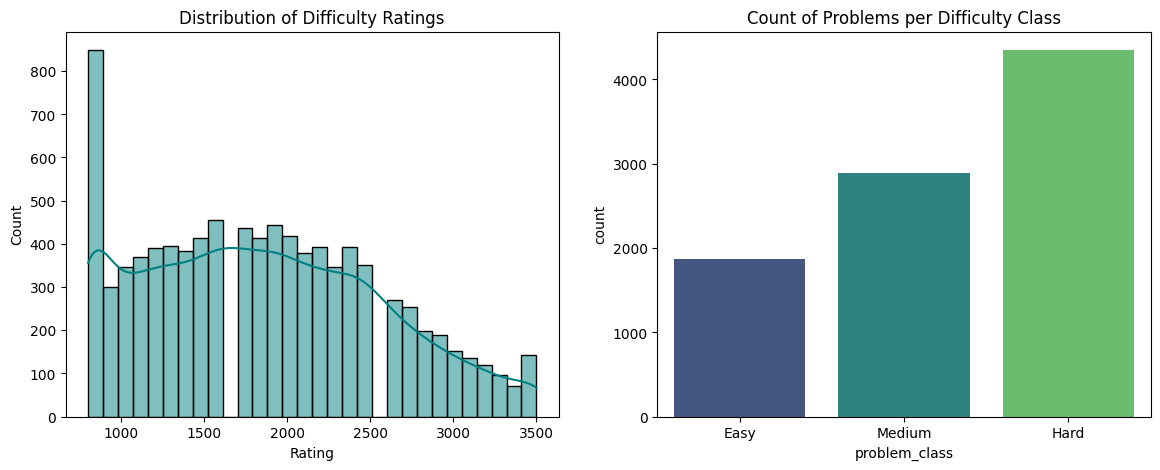

In [7]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['rating'], bins=30, kde=True, color='teal')
plt.title('Distribution of Difficulty Ratings')
plt.xlabel('Rating')

# 2. Class Balance (Bar Chart)
plt.subplot(1, 2, 2)
sns.countplot(x='problem_class', data=df, order=['Easy', 'Medium', 'Hard'], palette='viridis')
plt.title('Count of Problems per Difficulty Class')
plt.show()

In [8]:
df['rating'].value_counts().sort_values()

rating
3400.0     70
3300.0     96
3200.0    120
3100.0    135
3500.0    142
3000.0    151
2900.0    188
2800.0    198
2700.0    254
2600.0    271
900.0     299
1000.0    347
2300.0    347
2500.0    352
1100.0    369
2100.0    379
1400.0    384
1200.0    391
2400.0    392
2200.0    393
1300.0    394
1500.0    413
1800.0    414
2000.0    418
1700.0    436
1900.0    443
1600.0    455
800.0     849
Name: count, dtype: int64

/tmp/ipykernel_17/1298930620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['desc_len'] = df['description'].str.split().str.len()
/tmp/ipykernel_17/1298930620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input_len'] = df['input_format'].str.split().str.len()
/tmp/ipykernel_17/1298930620.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=

Text(0.5, 1.0, 'Input Description Length by Difficulty')

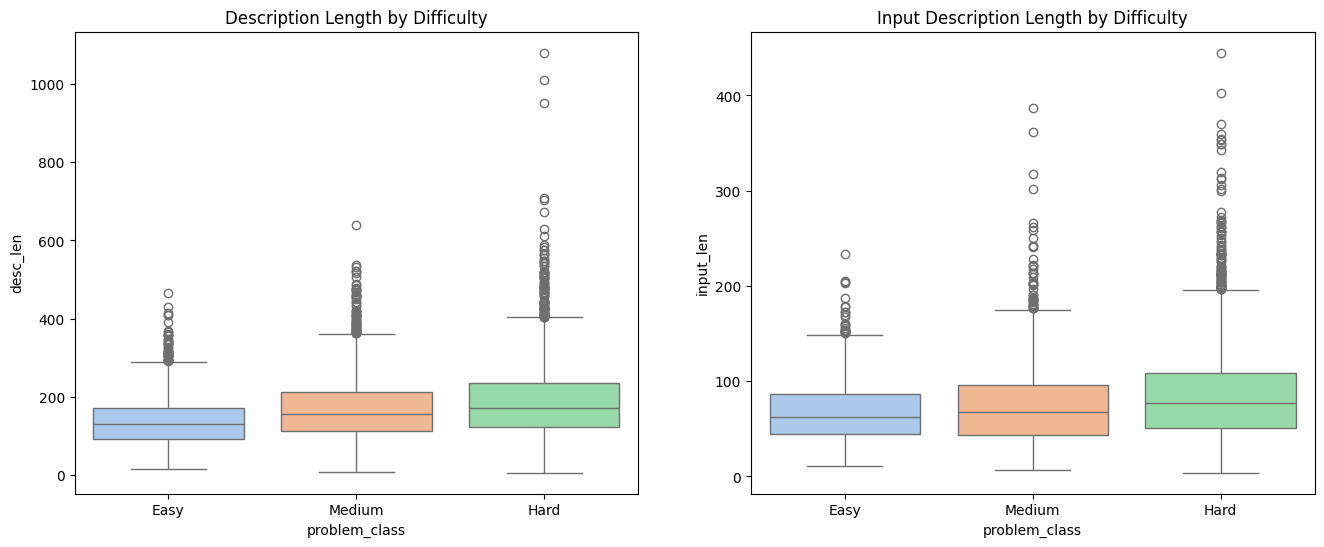

In [9]:
df['desc_len'] = df['description'].str.split().str.len()
df['input_len'] = df['input_format'].str.split().str.len()

# Boxplot of Length vs Difficulty
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='problem_class', y='desc_len', data=df, order=['Easy', 'Medium', 'Hard'], ax=axes[0], palette="pastel")
axes[0].set_title('Description Length by Difficulty')
# axes[0].set_ylim(0, 500)  # Limit zoom for better view

sns.boxplot(x='problem_class', y='input_len', data=df, order=['Easy', 'Medium', 'Hard'], ax=axes[1], palette="pastel")
axes[1].set_title('Input Description Length by Difficulty')
# axes[1].set_ylim(0, 200)

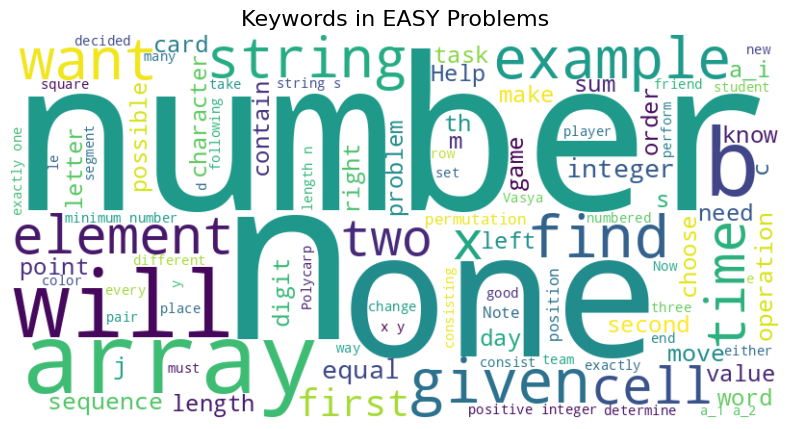

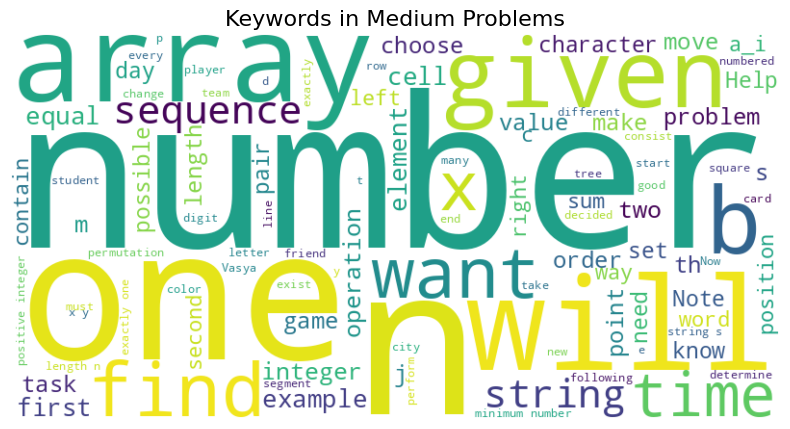

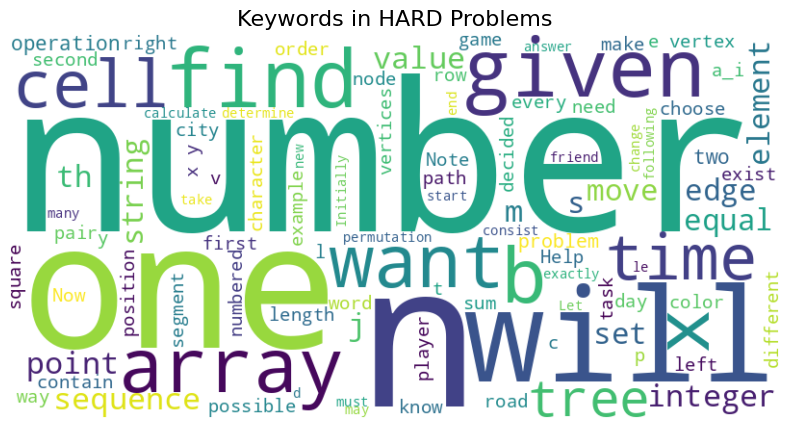

In [10]:
# Function to generate word cloud per class
def plot_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(" ".join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Easy Problems
plot_wordcloud(df[df['problem_class']=='Easy']['description'], "Keywords in EASY Problems")

# Medium Problems
plot_wordcloud(df[df['problem_class']=='Medium']['description'], "Keywords in Medium Problems")

# Hard Problems
plot_wordcloud(df[df['problem_class']=='Hard']['description'], "Keywords in HARD Problems")

/tmp/ipykernel_17/4197663468.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y), y=list(x), palette="magma")


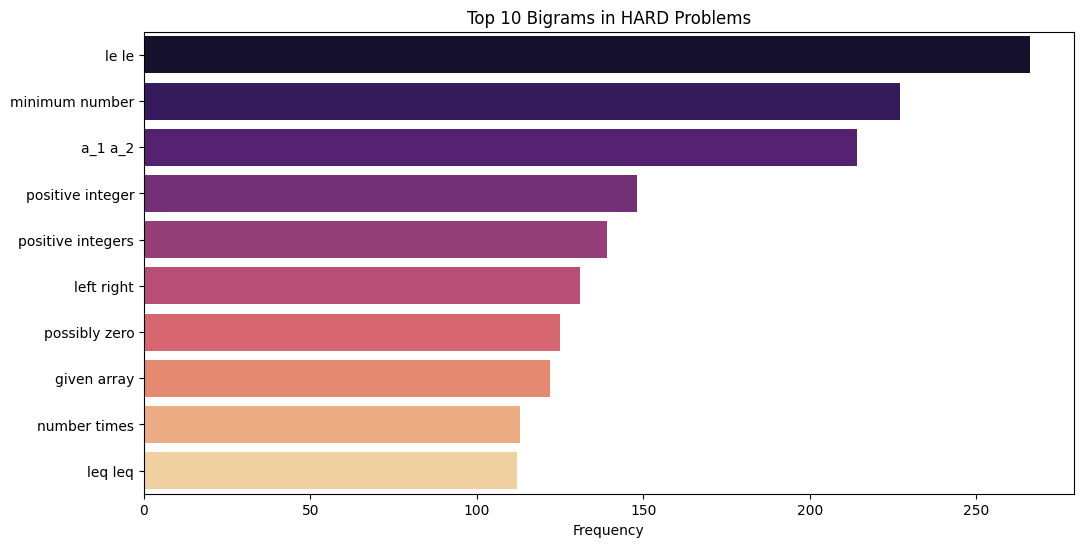

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Get top bigrams for Hard problems
top_bi_hard = get_top_ngrams(df[df['problem_class']=='Easy']['description'], n=2)
x, y = zip(*top_bi_hard)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(y), y=list(x), palette="magma")
plt.title("Top 10 Bigrams in HARD Problems")
plt.xlabel("Frequency")
plt.show()

/tmp/ipykernel_17/1853387833.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_n_constraint'] = df['input_format'].apply(extract_primary_constraint)
/tmp/ipykernel_17/1853387833.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_n'] = df['real_n_constraint'].apply(lambda x: np.log10(x) if x > 0 else 0)
/tmp/ipykernel_17/1853387833.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

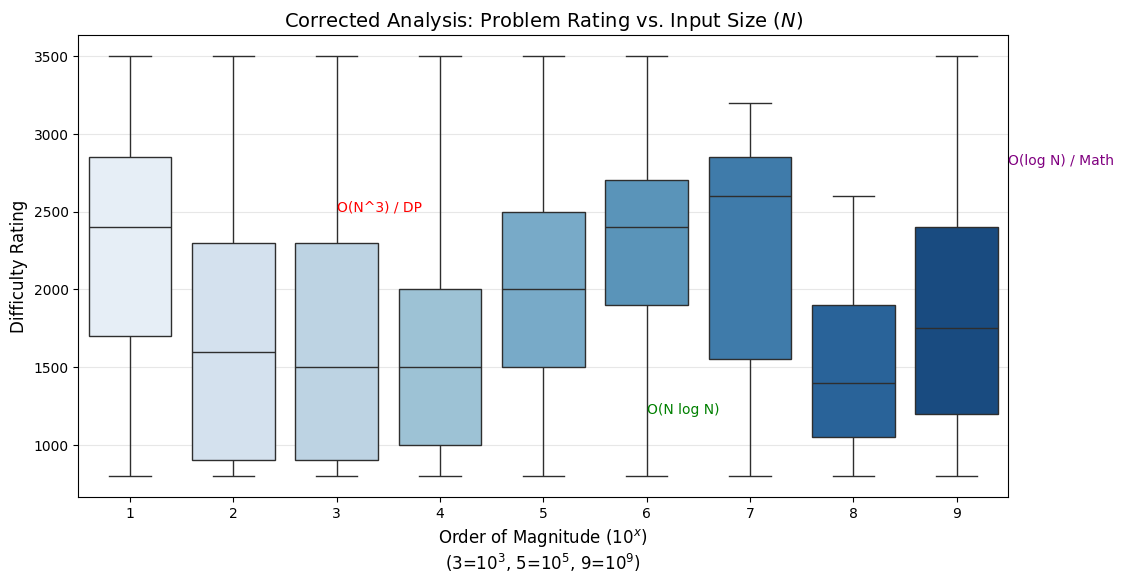

In [12]:
import re
import numpy as np
import pandas as pd

def extract_primary_constraint(text):
    """
    Extracts the algorithmic complexity constraint (N), ignoring value constraints (ai).
    Prioritizes N, M, Length, Size over generic numbers.
    """
    if pd.isna(text): return None
    text = text.lower()
    
    pattern_var_constraint = r'(?:\b(n|m|k|t|len|length|size|count)\b)\s*(?:\\le|\\leq|<=|<|is|up to)\s*(?:10\s*[\^|\*\*]\s*(\d+)|\b(\d+)\b)'
    
    matches = re.findall(pattern_var_constraint, text)
    
    candidates = []
    
    for var, power, raw_num in matches:
        # Convert to actual number
        if power: 
            val = 10 ** int(power)
        else: 
            val = int(raw_num)
            
        if val < 10: continue
        
        candidates.append(val)
        
    if not candidates:
        # Fallback: Look for "10^x" but ignore 10^9 or 10^18 if 10^5 exists
        all_powers = re.findall(r'10\s*[\^|\*\*]\s*(\d+)', text)
        candidates = [10**int(p) for p in all_powers]
    
    if not candidates:
        return 0

    # 2. Smart Selection Logic
    uniq_cands = sorted(list(set(candidates)))
    
    # If we have 10^5 and 10^9, pick 10^5 (Standard Array Problem)
    # If we ONLY have 10^9, keep it (Math/Number Theory Problem)
    complexity_candidates = [x for x in uniq_cands if 50 <= x <= 2000000]
    
    if complexity_candidates:
        return max(complexity_candidates)
    
    return max(uniq_cands)

# --- Apply to DataFrame ---
df['real_n_constraint'] = df['input_format'].apply(extract_primary_constraint)
df['log_n'] = df['real_n_constraint'].apply(lambda x: np.log10(x) if x > 0 else 0)


subset = df[df['real_n_constraint'] > 10]

plt.figure(figsize=(12, 6))

# Boxplot to show distribution of Difficulty for different Order of Magnitudes
subset['order_of_magnitude'] = subset['log_n'].round().astype(int)

# Plot
sns.boxplot(x='order_of_magnitude', y='rating', data=subset, palette="Blues")

plt.title("Corrected Analysis: Problem Rating vs. Input Size ($N$)", fontsize=14)
plt.xlabel("Order of Magnitude ($10^x$) \n(3=$10^3$, 5=$10^5$, 9=$10^9$)", fontsize=12)
plt.ylabel("Difficulty Rating", fontsize=12)

# Add annotations explaining the complexity classes
plt.text(2, 2500, "O(N^3) / DP", color='red', fontsize=10)
plt.text(5, 1200, "O(N log N)", color='green', fontsize=10)
plt.text(8.5, 2800, "O(log N) / Math", color='purple', fontsize=10)

plt.grid(True, axis='y', alpha=0.3)
plt.show()


In [13]:
# Feature Engineering: Combine all text fields
df['full_text'] = (
    df['title'] + " " + 
    df['description'] + " " + 
    df['input_format'] + " " + 
    df['output_format']
)

# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

df['clean_text'] = df['full_text'].apply(clean_text)

/tmp/ipykernel_17/3572926574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = (
/tmp/ipykernel_17/3572926574.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['full_text'].apply(clean_text)


In [14]:
# 3. Split Data
X = df['clean_text']
y_class = df['problem_class']
y_score = df['rating']

# Split: 80% train, 20% test
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=7
)

In [15]:
# 4. Define Pipelines (TF-IDF + Model)
print("Training Classification Model...")
class_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('classifier', RandomForestClassifier(n_estimators=1000, random_state=42))
])
class_pipeline.fit(X_train, y_class_train)

print("Training Regression Model...")
score_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))
])
score_pipeline.fit(X_train, y_score_train)

Training Classification Model...
Training Regression Model...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('regressor',
                 RandomForestRegressor(n_estimators=1000, random_state=42))])

In [16]:
# 5. Evaluation
print("\n--- Evaluation Results ---")
y_pred_class = class_pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_class_test, y_pred_class))

y_pred_score = score_pipeline.predict(X_test)
mae = mean_absolute_error(y_score_test, y_pred_score)
print(f"Regression MAE: {mae:.2f} (Average error in difficulty points)")


--- Evaluation Results ---
Classification Report:
              precision    recall  f1-score   support

        Easy       0.62      0.40      0.48       372
        Hard       0.63      0.87      0.73       890
      Medium       0.45      0.30      0.36       558

    accuracy                           0.60      1820
   macro avg       0.57      0.52      0.53      1820
weighted avg       0.58      0.60      0.57      1820

Regression MAE: 470.80 (Average error in difficulty points)


In [17]:
test = load_dataset("open-r1/codeforces", split="test")
test_df = pd.DataFrame(test)

In [18]:
test_df = test_df.dropna(subset=['description', 'input_format', 'output_format', 'rating'])
test_df['problem_class']  = test_df['rating'].apply(classify_difficulty)

test_df['full_text'] = (
    test_df['title'] + " " + 
    test_df['description'] + " " + 
    test_df['input_format'] + " " + 
    test_df['output_format']
)

y_test_class = test_df['problem_class']
y_test_rating = test_df['rating']
test_X = test_df['full_text'].apply(clean_text)

In [19]:
print("\n--- Evaluation-2 Results ---")
y_pred_class = class_pipeline.predict(test_X)
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

y_pred_score = score_pipeline.predict(test_X)
mae = mean_absolute_error(y_test_rating, y_pred_score)
print(f"Regression MAE: {mae:.2f} (Average error in difficulty points)")


--- Evaluation-2 Results ---
Classification Report:
              precision    recall  f1-score   support

        Easy       0.74      0.59      0.66       116
        Hard       0.75      0.76      0.76       216
      Medium       0.37      0.44      0.40       112

    accuracy                           0.64       444
   macro avg       0.62      0.60      0.61       444
weighted avg       0.65      0.64      0.64       444

Regression MAE: 508.78 (Average error in difficulty points)


In [20]:
# 6. Save Models
print("\nSaving models...")
joblib.dump(class_pipeline, 'model_class.pkl')
joblib.dump(score_pipeline, 'model_score.pkl')
print("Done! Models saved as 'model_class.pkl' and 'model_score.pkl'.")


Saving models...
Done! Models saved as 'model_class.pkl' and 'model_score.pkl'.
